# Univariate LSTM  

## Load Packages

In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow import keras

## Load Data

In [2]:
path = os.getcwd()
path = path.replace('modeling', 'data_preprocessing')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = path+'/'+file
df = pd.read_csv(csv_path)
df['date']=pd.to_datetime(df['date'])

In [3]:
# Univariate data
uv_data = df[df.columns[:2]].set_index(df.columns[0])
uv_data =  uv_data.rename(columns = {df.columns[1]:'target'})
data = np.array(uv_data)

### Data Preprocessing

### Scale Data

In [4]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [5]:
scaled_data, scaler = scale_data(data)

## Modeling

In [6]:
def create_dataset(data, look_back=5, n_features=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :n_features])
        y.append(data[i, 0])
    return np.array(X), np.array(y).reshape(len(y),1)

In [7]:
def train_val_test(X, y, look_back = 5, test_size=12, val_size=12):
    X_train, y_train = X[:-(test_size+val_size)], y[:-(test_size+val_size)]
    X_val, y_val = X[-(test_size+val_size):-(test_size)], y[-(test_size+val_size):-(test_size)]
    X_test, y_test = X[-(test_size):], y[-(test_size):]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.models import load_model

In [9]:
def lstm_model(X_train, y_train, X_val, y_val, n_features, look_back, batch_size, learning_rate, epochs, stateful=True, LSTM_units=64, add_dense=0):
    model = Sequential()
    if stateful:
        model.add(LSTM(units=LSTM_units, batch_input_shape = (batch_size, look_back, n_features), stateful=stateful))
        if add_dense>0:
            model.add(Dense(add_dense, activation='relu'))
    else:
        model.add(LSTM(units=LSTM_units, input_shape = (look_back, n_features)))
        if add_dense>0:
            model.add(Dense(add_dense, activation='relu'))
    model.add(Dense(1))

    #model.summary()

    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    optimizer=Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer, metrics=[RootMeanSquaredError()])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], verbose=0)

    best_train_loss = min(history.history['loss'])
    best_train_rmse = min(history.history['root_mean_squared_error'])
    best_val_loss = min(history.history['val_loss'])
    best_val_rmse = min(history.history['val_root_mean_squared_error'])

    print(f"Best Train loss: {best_train_loss}")
    print(f"Lowest Train RMSE: {best_train_rmse}")
    print(f"Best Validation loss: {best_val_loss}")
    print(f"Lowest Validation RMSE: {best_val_rmse}")

    return load_model('best_model.h5')

In [10]:
#check if model is stateful
def is_lstm_stateful(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.LSTM):
            return layer.stateful
    return None

In [11]:
def make_predictions(X, model, look_back, n_features):
    predictions = []
    stateful = is_lstm_stateful(model)    #check if model was stateful
    if stateful:
        for i in range(len(X)):
            sample = np.reshape(X[i], (1, look_back, n_features))
            predictions.append(model.predict(sample, verbose=0))
        predictions = np.array(predictions)
    else:
        predictions = model.predict(X, verbose=0)
    return predictions.reshape(len(predictions),1)

In [12]:
# We can also check how the model makes future predictions using it's own predictions
def future_predictions(X, model, look_back, n_features):
    predictions = []
    for i in range(len(X)):
        if len(predictions)<look_back:
            sample = np.reshape(np.vstack((X[i][:(look_back-len(predictions))], np.reshape(predictions, (len(predictions),1)))), (1, look_back, n_features))
        else:
            sample = np.reshape(predictions[(i-look_back):i], (1, look_back, n_features))
        predictions.append(model.predict(sample, verbose=0))
    predictions = np.array(predictions)
    return predictions.reshape(len(predictions),1)

In [13]:
def inverse_predictions(scaled_y):
    y=scaler.inverse_transform(np.hstack((scaled_y, np.zeros((scaled_y.shape[0], uv_data.shape[0]-1)))))[:,0]
    return y

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def print_metrics(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    directional_accuracy = np.mean((np.sign(actuals[1:] - actuals[:-1]) == np.sign(predictions[1:] - predictions[:-1]))) *100

    print(f"RMSE: {rmse:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R2: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

In [15]:
def comparison_df(sf_train_val_pred, sl_train_val_pred, sf_y_pred, sl_y_pred, sf_y_futr, sl_y_futr, look_back):
    compare_df= uv_data[look_back:].copy()
    compare_df['stateful_train_prediction']=list(np.hstack((sf_train_val_pred, sf_y_pred)))
    compare_df['stateless_train_prediction']=list(np.hstack((sl_train_val_pred, sl_y_pred)))
    compare_df['stateful_future_prediction']=list(np.hstack((sf_train_val_pred, sf_y_futr)))
    compare_df['stateless_future_prediction']=list(np.hstack((sl_train_val_pred, sl_y_futr)))
    return compare_df

In [59]:
import matplotlib.pyplot as plt
def plot_predictions(df, test_size, val_size):
    plt.figure(figsize=(20,20))

    plt.subplot(411)
    plt.plot(df.index[-(test_size+val_size)*2:], df['target'][-(test_size+val_size)*2:], color='blue', label='Original Data')
    plt.plot(df.index[-(test_size+val_size)*2:-(test_size+val_size)], df['stateful_train_prediction'][-(test_size+val_size)*2:-(test_size+val_size)], color='green', label='Train Predictions')
    plt.plot(df.index[-(test_size+val_size):-(test_size)], df['stateful_train_prediction'][-(test_size+val_size):-(test_size)], color='yellow', label='Validation Predictions')
    plt.plot(df.index[-(test_size):], df['stateful_train_prediction'][-(test_size):], color='red', label='Test Predictions')
    plt.legend()
    plt.title('Actual data vs Individual Predictions - Stateful model')
    plt.xlabel('Date')
    plt.ylabel('Target')

    plt.subplot(412)
    plt.plot(df.index[-(test_size+val_size)*2:], df['target'][-(test_size+val_size)*2:], color='blue', label='Original Data')
    plt.plot(df.index[-(test_size+val_size)*2:-(test_size+val_size)], df['stateless_train_prediction'][-(test_size+val_size)*2:-(test_size+val_size)], color='green', label='Train Predictions')
    plt.plot(df.index[-(test_size+val_size):-(test_size)], df['stateless_train_prediction'][-(test_size+val_size):-(test_size)], color='yellow', label='Validation Predictions')
    plt.plot(df.index[-(test_size):], df['stateless_train_prediction'][-(test_size):], color='red', label='Test Predictions')
    plt.legend()
    plt.title('Actual data vs Individual Predictions - Stateless model')
    plt.xlabel('Date')
    plt.ylabel('Target')

    plt.subplot(413)
    plt.plot(df.index[-(test_size+val_size)*2:], df['target'][-(test_size+val_size)*2:], color='blue', label='Original Data')
    plt.plot(df.index[-(test_size+val_size)*2:-(test_size+val_size)], df['stateful_future_prediction'][-(test_size+val_size)*2:-(test_size+val_size)], color='green', label='Train Predictions')
    plt.plot(df.index[-(test_size+val_size):-(test_size)], df['stateful_future_prediction'][-(test_size+val_size):-(test_size)], color='yellow', label='Validation Predictions')
    plt.plot(df.index[-(test_size):], df['stateful_future_prediction'][-(test_size):], color='red', label='Test Predictions')
    plt.legend()
    plt.title('Actual data vs Individual Predictions - Stateful model')
    plt.xlabel('Date')
    plt.ylabel('Target')

    plt.subplot(414)
    plt.plot(df.index[-(test_size+val_size)*2:], df['target'][-(test_size+val_size)*2:], color='blue', label='Original Data')
    plt.plot(df.index[-(test_size+val_size)*2:-(test_size+val_size)], df['stateless_future_prediction'][-(test_size+val_size)*2:-(test_size+val_size)], color='green', label='Train Predictions')
    plt.plot(df.index[-(test_size+val_size):-(test_size)], df['stateless_future_prediction'][-(test_size+val_size):-(test_size)], color='yellow', label='Validation Predictions')
    plt.plot(df.index[-(test_size):], df['stateless_future_prediction'][-(test_size):], color='red', label='Test Predictions')
    plt.legend()
    plt.title('Actual data vs Individual Predictions - Stateless model')
    plt.xlabel('Date')
    plt.ylabel('Target')

    plt.show()


In [53]:
def LSTM_performance_check(look_back, n_features, test_size, val_size, batch_size, learning_rate, epochs, LSTM_units, add_dense):
    X, y = create_dataset(scaled_data, look_back, n_features)
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test(X, y, look_back=look_back, test_size=test_size, val_size=val_size)

    sf_model = lstm_model(X_train, y_train, X_val, y_val, n_features, look_back, batch_size, learning_rate, epochs, stateful=True, LSTM_units=LSTM_units, add_dense=add_dense)
    sl_model = lstm_model(X_train, y_train, X_val, y_val, n_features, look_back, batch_size, learning_rate, epochs, stateful=False, LSTM_units=LSTM_units, add_dense=add_dense)

    sf_predictions = make_predictions(X_test, sf_model, look_back, n_features)
    sl_predictions = make_predictions(X_test, sl_model, look_back, n_features)

    sf_y_pred=inverse_predictions(sf_predictions)
    sl_y_pred=inverse_predictions(sl_predictions)
    actual_y_test=inverse_predictions(y_test)

    sf_futr_pred = future_predictions(X_test, sf_model, look_back, n_features)
    sl_futr_pred = future_predictions(X_test, sl_model, look_back, n_features)

    sf_y_futr=inverse_predictions(sf_futr_pred)
    sl_y_futr=inverse_predictions(sl_futr_pred)

    print("Stateful Model - Test Predictions")
    print_metrics(sf_y_pred, actual_y_test)
    print("Stateless Model - Test Predictions")
    print_metrics(sl_y_pred, actual_y_test)
    print("Stateful Model - Future Predictions")
    print_metrics(sf_y_futr, actual_y_test)
    print("Stateless Model - Future Predictions")
    print_metrics(sl_y_futr, actual_y_test)
    
    sf_train_val_pred = inverse_predictions(make_predictions(X[:-test_size], sf_model, look_back, n_features))
    sl_train_val_pred = inverse_predictions(make_predictions(X[:-test_size], sl_model, look_back, n_features))

    compare_df=comparison_df(sf_train_val_pred, sl_train_val_pred, sf_y_pred, sl_y_pred, sf_y_futr, sl_y_futr, look_back)

    plot_predictions(compare_df, test_size, val_size)


    

Best Train loss: 0.002528571989387274
Lowest Train RMSE: 0.05028490722179413
Best Validation loss: 0.006677242927253246
Lowest Validation RMSE: 0.08171439915895462
Best Train loss: 0.0024153036065399647
Lowest Train RMSE: 0.049145739525556564
Best Validation loss: 0.006629536859691143
Lowest Validation RMSE: 0.08142197132110596
Stateful Model - Test Predictions
RMSE: 1.96
MSE: 3.83
R2: 0.90
MAE: 1.67
MAPE: 1.71%
Directional Accuracy: 41.18%
Stateless Model - Test Predictions
RMSE: 2.78
MSE: 7.70
R2: 0.80
MAE: 2.01
MAPE: 2.03%
Directional Accuracy: 29.41%
Stateful Model - Future Predictions
RMSE: 3.65
MSE: 13.32
R2: 0.65
MAE: 3.21
MAPE: 3.25%
Directional Accuracy: 41.18%
Stateless Model - Future Predictions
RMSE: 14.21
MSE: 202.00
R2: -4.36
MAE: 13.74
MAPE: 14.18%
Directional Accuracy: 35.29%


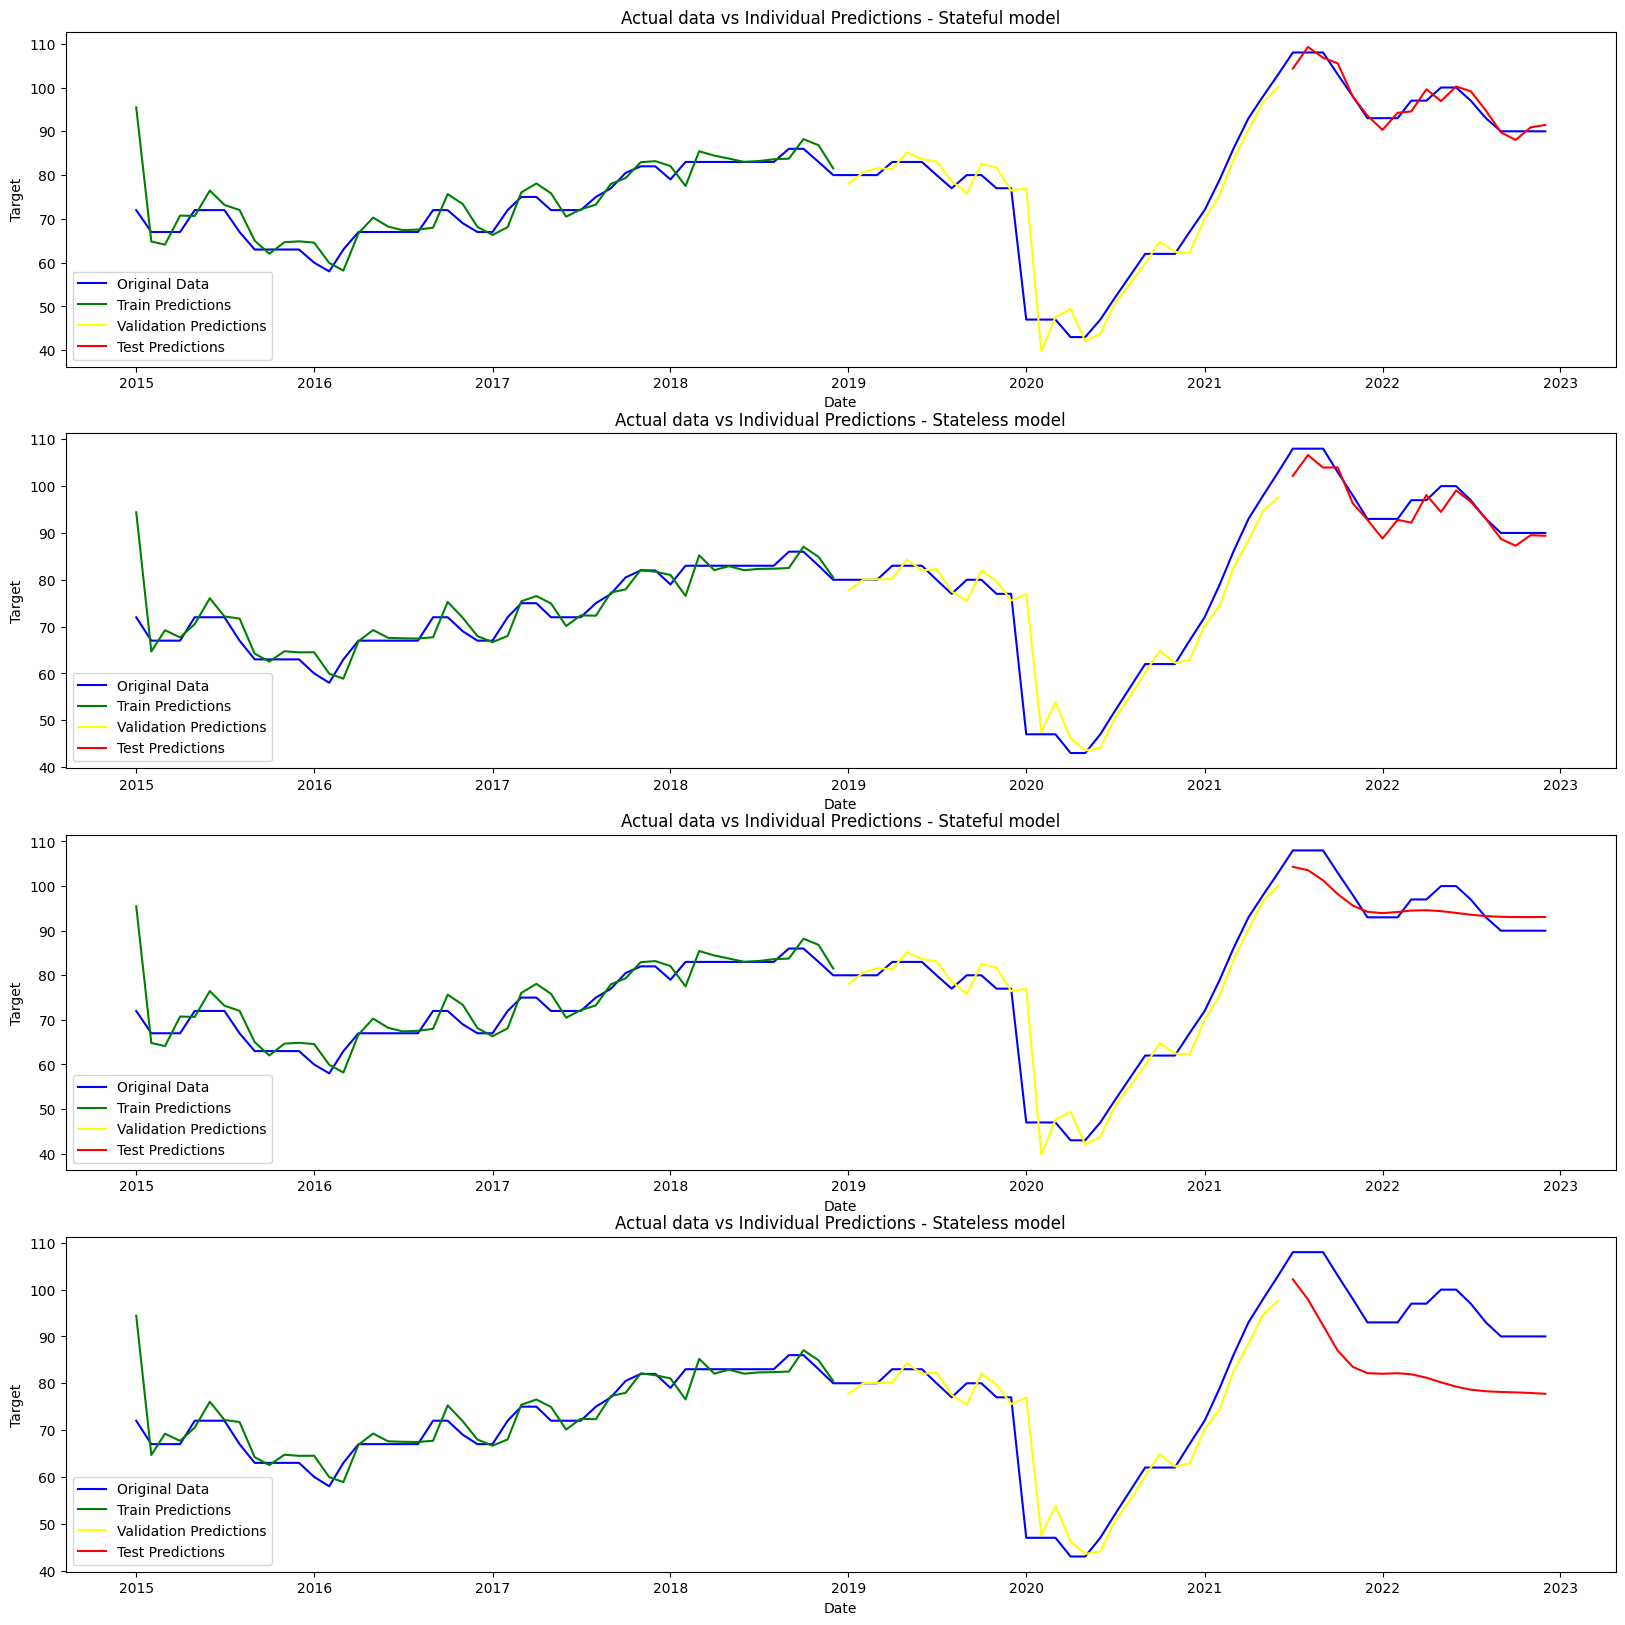

In [66]:
look_back = 24
n_features = 1

test_size = 18
val_size =30

batch_size= 1
learning_rate=  0.005
epochs= 50
LSTM_units=32
add_dense=32

LSTM_performance_check(look_back, n_features, test_size, val_size, batch_size, learning_rate, epochs, LSTM_units, add_dense)

### Rough

In [19]:
# look_back = 24
# n_features = 1
# X, y = create_dataset(scaled_data, look_back, n_features)

In [20]:
# test_size = 18
# val_size =30
# X_train, y_train, X_val, y_val, X_test, y_test = train_val_test(X, y, look_back=look_back, test_size=test_size, val_size=val_size)

In [21]:
# batch_size= 1
# learning_rate=  0.001
# epochs= 50
# LSTM_units=64
# add_dense=32

# model1 = lstm_model(X_train, y_train, X_val, y_val, n_features, look_back, batch_size, learning_rate, epochs, stateful=True, LSTM_units=LSTM_units, add_dense=add_dense)

In [22]:
# model2 = lstm_model(X_train, y_train, X_val, y_val, n_features, look_back, batch_size, learning_rate, epochs, stateful=False, LSTM_units=LSTM_units, add_dense=add_dense)

In [23]:
# predictions1 = make_predictions(X_test, model1)
# predictions2 = make_predictions(X_test, model2)

In [24]:
# y_pred1=inverse_predictions(predictions1)
# y_pred2=inverse_predictions(predictions2)
# y_test_actual=inverse_predictions(y_test)

In [25]:
# print("Stateful Model")
# print_metrics(y_pred1, y_test_actual)

In [26]:
# print("Stateless Model")
# print_metrics(y_pred2, y_test_actual)

In [27]:
# compare1 = uv_data[look_back:].copy()
# compare1['prediction']=list(inverse_predictions(make_predictions(X, model1)))

In [28]:
# compare2 = uv_data[look_back:].copy()
# compare2['prediction']=list(inverse_predictions(make_predictions(X, model2)))

In [29]:
# print_metrics(compare1.target, compare1.prediction)

In [30]:
# print_metrics(compare2.target, compare2.prediction)

In [31]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,5))
# plt.plot(compare1.index, compare1['target'], color='blue', label='Original Data')
# plt.plot(compare1.index[:-(test_size+val_size)], compare1['prediction'][:-(test_size+val_size)], color='green', label='Train Predictions')
# plt.plot(compare1.index[-(test_size+val_size):-(test_size)], compare1['prediction'][-(test_size+val_size):-(test_size)], color='yellow', label='Validation Predictions')
# plt.plot(compare1.index[-(test_size):], compare1['prediction'][-(test_size):], color='red', label='Test Predictions')
# plt.legend()
# plt.title('Univariate LSTM Time Series Prediction with Validation')
# plt.xlabel('Date')
# plt.ylabel('Target')
# plt.show()

In [32]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,5))
# plt.plot(compare2.index, compare2['target'], color='blue', label='Original Data')
# plt.plot(compare2.index[:-(test_size+val_size)], compare2['prediction'][:-(test_size+val_size)], color='green', label='Train Predictions')
# plt.plot(compare2.index[-(test_size+val_size):-(test_size)], compare2['prediction'][-(test_size+val_size):-(test_size)], color='yellow', label='Validation Predictions')
# plt.plot(compare2.index[-(test_size):], compare2['prediction'][-(test_size):], color='red', label='Test Predictions')
# plt.legend()
# plt.title('Univariate LSTM Time Series Prediction with Validation')
# plt.xlabel('Date')
# plt.ylabel('Target')
# plt.show()

In [33]:


# future1 = future_predictions(X_test, model1, look_back)
# future2 = future_predictions(X_test, model2, look_back)

In [34]:
# y_futr1=inverse_predictions(future1)
# y_futr2=inverse_predictions(future2)

In [35]:
# print("Stateful Model")
# print_metrics(y_futr1, y_test_actual)

In [36]:
# print("Stateless Model")
# print_metrics(y_futr2, y_test_actual)

In [37]:
# compare_future1 = uv_data[look_back:].copy()
# compare_future1['prediction']=list(np.hstack((inverse_predictions(make_predictions(X[:-test_size], model1)), y_futr1)))
# compare_future2 = uv_data[look_back:].copy()
# compare_future2['prediction']=list(np.hstack((inverse_predictions(make_predictions(X[:-test_size], model2)), y_futr2)))

In [38]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,5))
# plt.plot(compare_future1.index, compare_future1['target'], color='blue', label='Original Data')
# plt.plot(compare_future1.index[:-(test_size+val_size)], compare_future1['prediction'][:-(test_size+val_size)], color='green', label='Train Predictions')
# plt.plot(compare_future1.index[-(test_size+val_size):-(test_size)], compare_future1['prediction'][-(test_size+val_size):-(test_size)], color='yellow', label='Validation Predictions')
# plt.plot(compare_future1.index[-(test_size):], compare_future1['prediction'][-(test_size):], color='red', label='Test Predictions')
# plt.legend()
# plt.title('Univariate LSTM Time Series Prediction with Validation')
# plt.xlabel('Date')
# plt.ylabel('Target')
# plt.show()

In [39]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,5))
# plt.plot(compare_future2.index, compare_future2['target'], color='blue', label='Original Data')
# plt.plot(compare_future2.index[:-(test_size+val_size)], compare_future2['prediction'][:-(test_size+val_size)], color='green', label='Train Predictions')
# plt.plot(compare_future2.index[-(test_size+val_size):-(test_size)], compare_future2['prediction'][-(test_size+val_size):-(test_size)], color='yellow', label='Validation Predictions')
# plt.plot(compare_future2.index[-(test_size):], compare_future2['prediction'][-(test_size):], color='red', label='Test Predictions')
# plt.legend()
# plt.title('Univariate LSTM Time Series Prediction with Validation')
# plt.xlabel('Date')
# plt.ylabel('Target')
# plt.show()

We can see that both univaraite models perform poorly in making future predictions for a long terms. We can use the model to predict future predictions for 1 or 2 months ahead